# K-Nearest Neighbor

## Table of contents

### [1. Libraries import and Data preparation](#1)

### [2. K-nearest neighbor on mean temperatures](#2)

### [3. K-nearest neighbor on all climate parameters](#3)

### [4. K-nearest neighbor on discriminated stations and all weather metrics](#4)

## 1. Libraries import and Data preparation
<div id='1'></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler


##to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Creating paths to the data folder of the project and to the folder for saving the charts
path_data = r"C:\Users\dacol\Documents\Data Project - careerfoundry\ClimateWins_ML\02 Data"

# Importing the unscaled dataframe
df_weather = pd.read_csv(os.path.join(path_data,'Original Data','Dataset-weather-prediction-dataset-processed.csv'), sep =',')

# Importing the rated dataframe for pleasant days
df_rate = pd.read_csv(os.path.join(path_data,'Original Data','Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'), sep =',')

In [3]:
print(df_weather.shape)
print(df_rate.shape)

(22950, 170)
(22950, 16)


In [5]:
df_rate.describe()

,DATE,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
count,2.295000e+04,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.000000,22950.0,22950.000000,22950.000000
mean,1.990984e+07,0.246797,0.348235,0.323791,0.194292,0.214989,0.216078,0.164444,0.277821,0.207669,0.446492,0.207712,0.155948,0.0,0.169673,0.051155
std,1.813833e+05,0.431157,0.476421,0.467931,0.395663,0.410824,0.411577,0.370686,0.447935,0.405647,0.497140,0.405679,0.362814,0.0,0.375354,0.220318
min,1.960010e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,1.975092e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,1.991060e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2.007021e+07,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,2.022103e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


**NOTE** : Sonnblick station only has 0 (unpleasant) days : either the data is incomplete, either it is never a good day in this high place of Austria.

In [8]:
#isolating the columns names from the rate df since some weather stations are missing
rate_columns = df_rate.columns.to_list()

In [10]:
#isolating the weather columns to check for the stations to trim
weather_columns = df_weather.columns.to_list()

In [12]:
#splitting the column names to isolate the stations names
answer_stations = [col.split('_')[0] for col in rate_columns if '_' in col ]

In [14]:
#keeping only the weather stations maatching the stations from the rates
weather_stations = [col for col in weather_columns if col.split('_')[0] in answer_stations]

In [16]:
#creating a new df with the desired columns
df_weather_new = df_weather[weather_stations]
df_weather_new.head()

,BASEL_cloud_cover,BASEL_wind_speed,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_snow_depth,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_snow_depth,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,7,2.1,0.85,1.018,0.32,0.09,0,0.7,6.5,0.8,...,5,0.88,1.0003,0.45,0.34,0,4.7,8.5,6.0,10.9
1,6,2.1,0.84,1.018,0.36,1.05,0,1.1,6.1,3.3,...,7,0.91,1.0007,0.25,0.84,0,0.7,8.9,5.6,12.1
2,8,2.1,0.90,1.018,0.18,0.30,0,0.0,8.5,5.1,...,7,0.91,1.0096,0.17,0.08,0,0.1,10.5,8.1,12.9
3,3,2.1,0.92,1.018,0.58,0.00,0,4.1,6.3,3.8,...,7,0.86,1.0184,0.13,0.98,0,0.0,7.4,7.3,10.6
4,6,2.1,0.95,1.018,0.65,0.14,0,5.4,3.0,-0.7,...,3,0.80,1.0328,0.46,0.00,0,5.7,5.7,3.0,8.4


In [18]:
#Preparing weather df with only the temperatures (exclusion of dates and stations of ROMA, TOURS & GDANSK) as X

X = df_weather_new

X.shape

(22950, 147)

In [20]:
#Preparing rating df with only the stations' daily rates (exclusion of dates)as y
y = df_rate.drop(['DATE'], axis=1)

y.shape

(22950, 15)

## 2. K-nearest neighbor on mean temperatures
<div id='2'></div>

In [23]:
#Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16065, 147)
(6885, 147)
(16065, 15)
(6885, 15)


In [18]:
#Run the model with neighbors equal to 1 to 4, test the accuracy
k_range = np.arange(1,4)
train_acc = np.empty(len(k_range))
test_acc = np.empty(len(k_range))
scores = {}
scores_list = []
for i, k in enumerate(k_range):
    print("i -", i)
    print("k -", k_range)
    knn = KNeighborsClassifier(n_neighbors=k)
    classifier = MultiOutputClassifier(knn, n_jobs=-1)
    ## Fit the model on the training data.
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    train_acc[i] = knn.score(X_train, np.array(y_train))
    test_acc[i] = knn.score(X_test, np.array(y_test))

i - 0
k - [1 2 3]


  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


i - 1
k - [1 2 3]
i - 2
k - [1 2 3]


<function matplotlib.pyplot.show(close=None, block=None)>

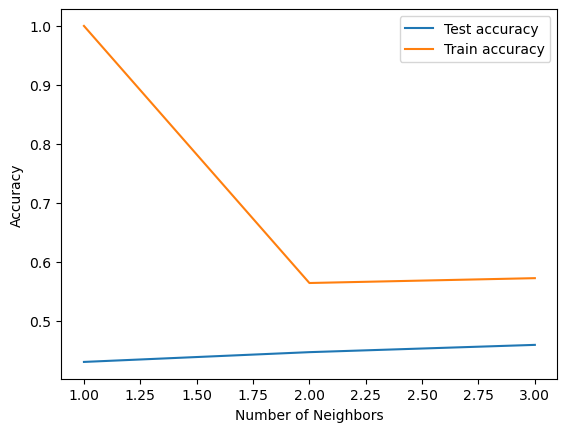

In [19]:
#plot the relationship between number of neighbors and accuracy
plt.plot(k_range, test_acc, label = 'Test accuracy')
plt.plot(k_range, train_acc, label = 'Train accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show

In [20]:
locations = list({x.split("_")[0] for x in df_rate.columns if x not in ["MONTH", "DATE"]})
locations.sort()
locations

['BASEL',
 'BELGRADE',
 'BUDAPEST',
 'DEBILT',
 'DUSSELDORF',
 'HEATHROW',
 'KASSEL',
 'LJUBLJANA',
 'MAASTRICHT',
 'MADRID',
 'MUNCHENB',
 'OSLO',
 'SONNBLICK',
 'STOCKHOLM',
 'VALENTIA']

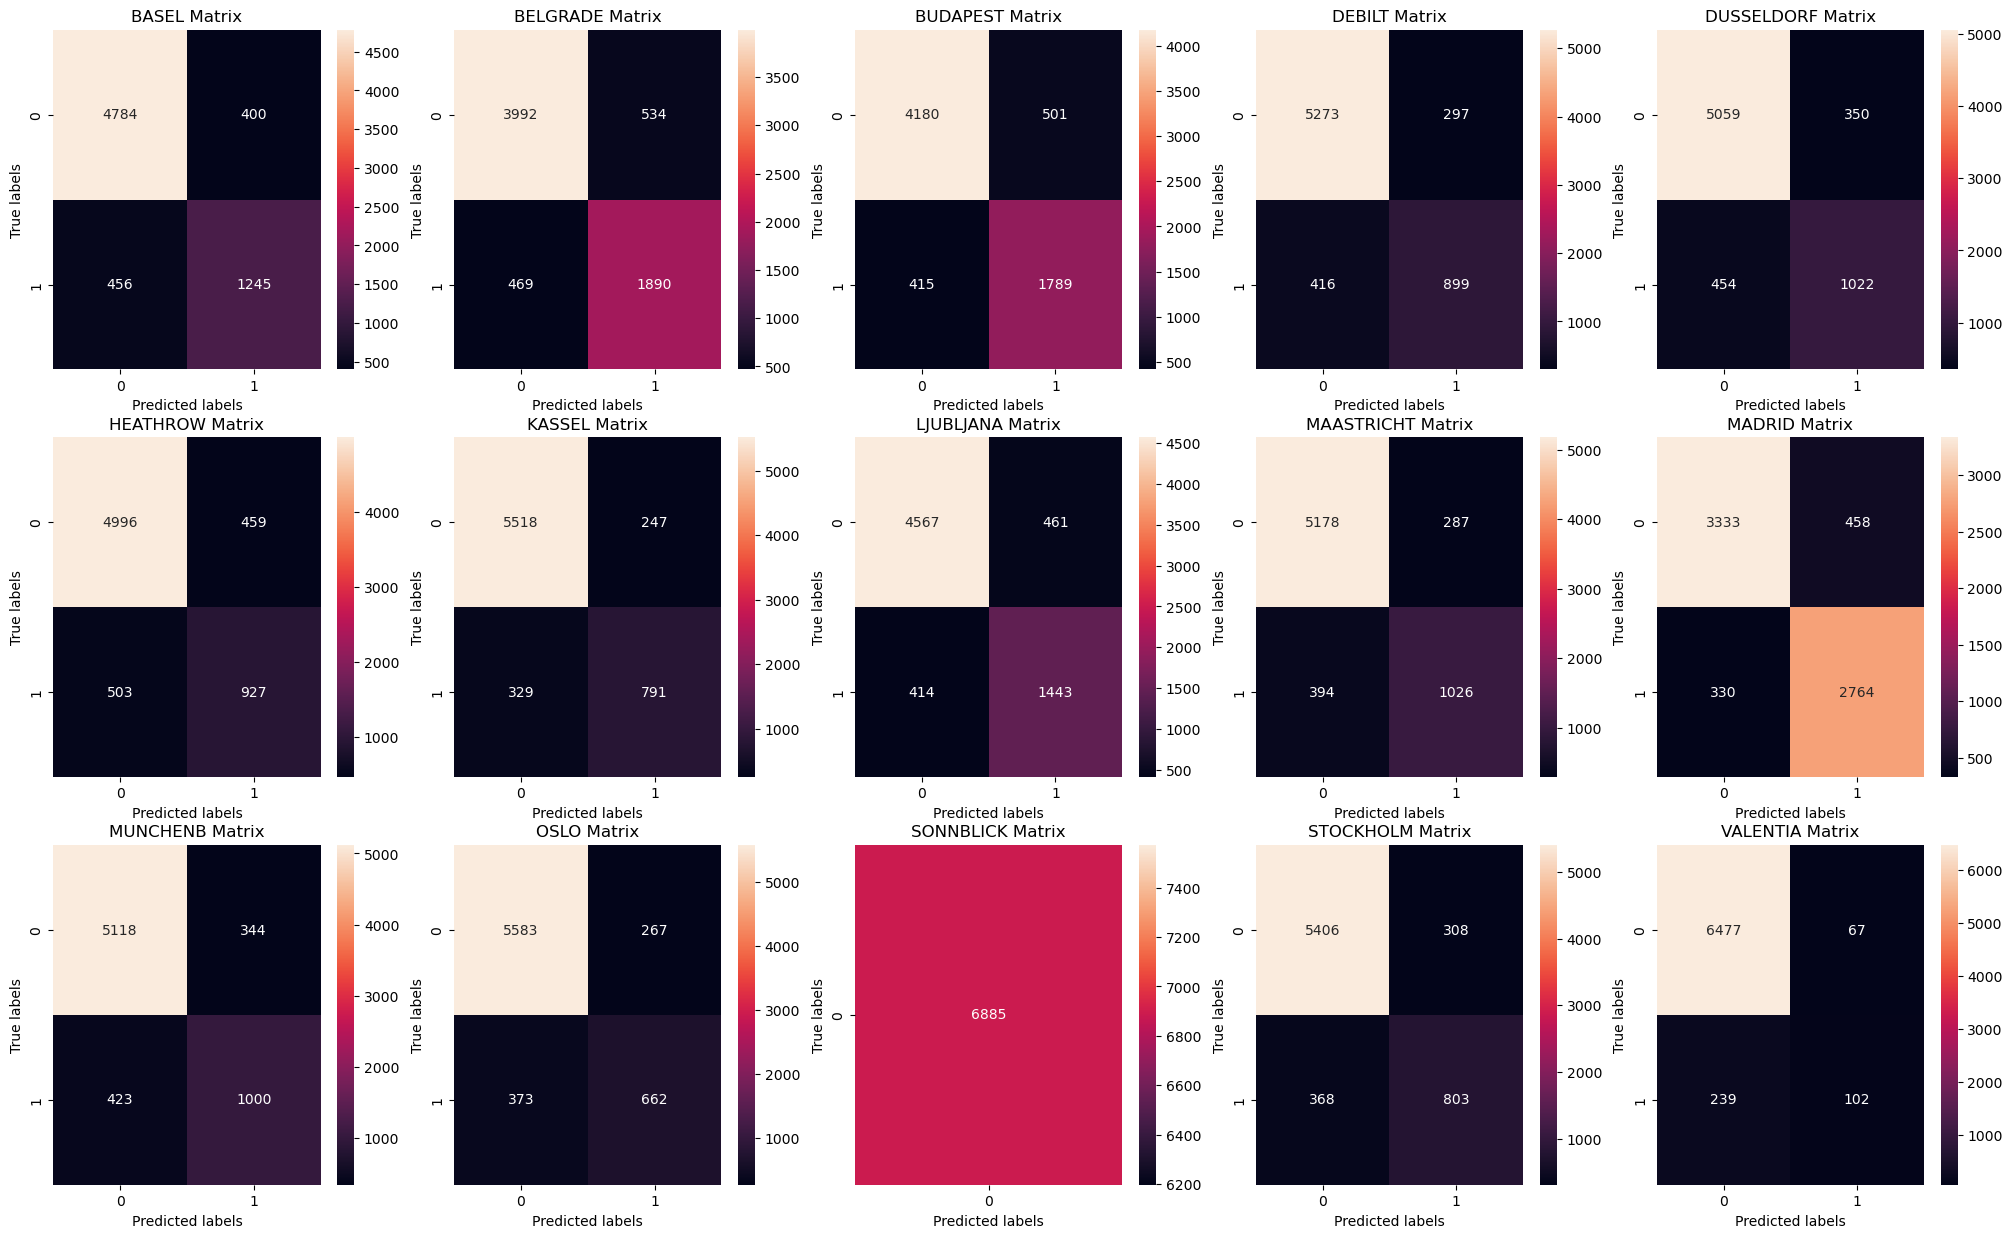

In [21]:
#Confusion matrix based on the last "k" in the sequence
key = "_pleasant_weather"
stations = []
figure, ax = plt.subplots(3, 5, figsize=(25,15))
labels = ['pleasant', 'unpleasant']   
count=0
for i in range(3):
    for j in range(5):
        name = locations[count]
        cm = confusion_matrix(y_test.loc[:,name+key], y_pred[:,count])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        ax[i,j] = sns.heatmap(cm, annot=True, fmt='g', ax=ax[i,j]);
        # labels, title and ticks
        ax[i,j].set_xlabel('Predicted labels');
        ax[i,j].set_ylabel('True labels'); 
        ax[i,j].set_title(name +' Matrix'); 
        #ax[i,j].xaxis.set_ticklabels(labels);
        #ax[i,j].yaxis.set_ticklabels(labels);
        count+=1

## 3. K-nearest neighbor on mean temperatures
<div id='3'></div>

In [23]:
X = df_weather.drop(['DATE', 'MONTH'], axis=1)

X.shape

(22950, 168)

In [24]:
y = df_rate.drop(['DATE'], axis=1)

y.shape

(22950, 15)

In [25]:
#Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16065, 168)
(6885, 168)
(16065, 15)
(6885, 15)


In [27]:
#Run the model with neighbors equal to 1 to 4, test the accuracy
k_range = np.arange(1,4)
train_acc = np.empty(len(k_range))
test_acc = np.empty(len(k_range))
scores = {}
scores_list = []
for i, k in enumerate(k_range):
    print("i -", i)
    print("k -", k_range)
    knn = KNeighborsClassifier(n_neighbors=k)
    classifier = MultiOutputClassifier(knn, n_jobs=-1)
    ## Fit the model on the training data.
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    train_acc[i] = knn.score(X_train, np.array(y_train))
    test_acc[i] = knn.score(X_test, np.array(y_test))

i - 0
k - [1 2 3]
i - 1
k - [1 2 3]
i - 2
k - [1 2 3]


<function matplotlib.pyplot.show(close=None, block=None)>

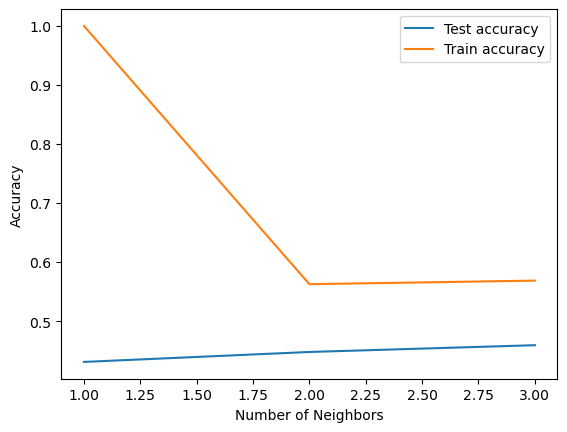

In [28]:
#plot the relationship between number of neighbors and accuracy
plt.plot(k_range, test_acc, label = 'Test accuracy')
plt.plot(k_range, train_acc, label = 'Train accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.savefig(r'C:\Users\dacol\Documents\Data Project - careerfoundry\ClimateWins_ML\04 Analysis\Visualizations\Neighbors_vs_accuracy-KNN.png', bbox_inches='tight', dpi=300)
plt.show

In [29]:
locations = list({x.split("_")[0] for x in df_rate.columns if x not in ["MONTH", "DATE"]})
locations.sort()
locations

['BASEL',
 'BELGRADE',
 'BUDAPEST',
 'DEBILT',
 'DUSSELDORF',
 'HEATHROW',
 'KASSEL',
 'LJUBLJANA',
 'MAASTRICHT',
 'MADRID',
 'MUNCHENB',
 'OSLO',
 'SONNBLICK',
 'STOCKHOLM',
 'VALENTIA']

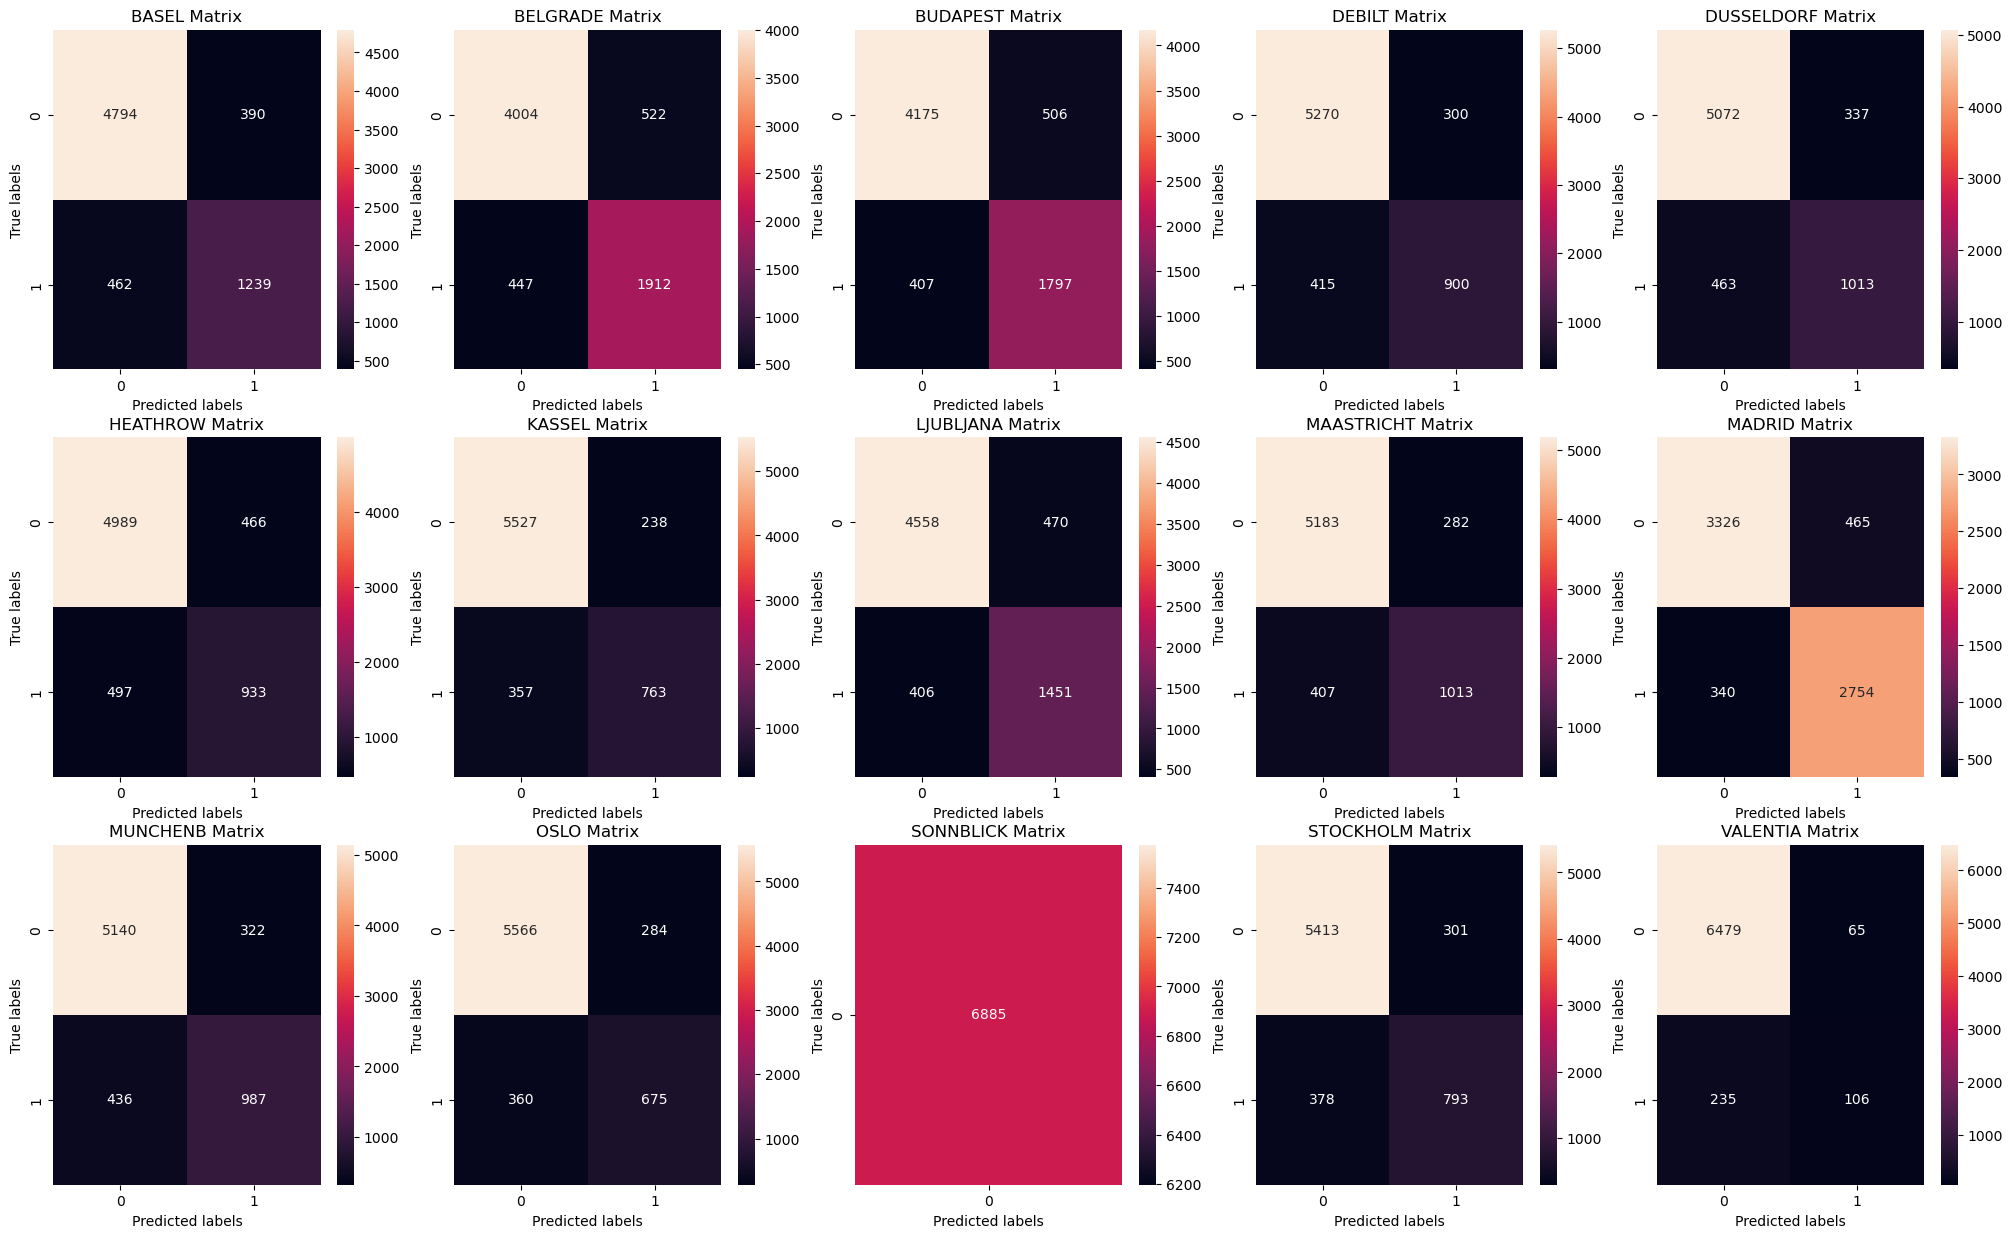

In [30]:
#Confusion matrix based on the last "k" in the sequence
key = "_pleasant_weather"
figure, ax = plt.subplots(3, 5, figsize=(25,15))
labels = ['pleasant', 'unpleasant']   
count=0
for i in range(3):
    for j in range(5):
        name = locations[count]
        cm = confusion_matrix(y_test.loc[:,name+key], y_pred[:,count])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        ax[i,j] = sns.heatmap(cm, annot=True, fmt='g', ax=ax[i,j]);
        # labels, title and ticks
        ax[i,j].set_xlabel('Predicted labels');
        ax[i,j].set_ylabel('True labels'); 
        ax[i,j].set_title(name +' Matrix'); 
        #ax[i,j].xaxis.set_ticklabels(labels);
        #ax[i,j].yaxis.set_ticklabels(labels);
        count+=1

plt.savefig(r'C:\Users\dacol\Documents\Data Project - careerfoundry\ClimateWins_ML\04 Analysis\Visualizations\CM-KNN.png', bbox_inches='tight', dpi=300)

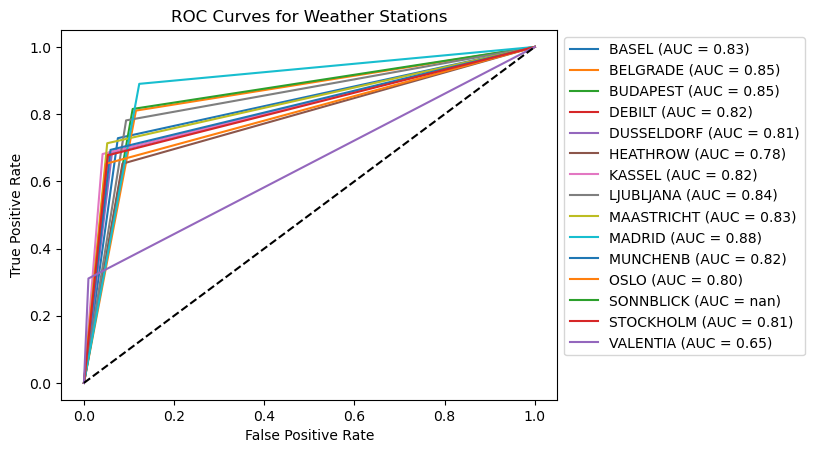

In [31]:
from sklearn.metrics import roc_curve, auc

for i, location in enumerate(locations):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{location} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Weather Stations')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.savefig(r'C:\Users\dacol\Documents\Data Project - careerfoundry\ClimateWins_ML\04 Analysis\Visualizations\ROC-KNN.png', bbox_inches='tight', dpi=300)
plt.show()


In [32]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score

# List of weather stations
stations = locations

# Initialize lists to store the metrics
precision_list = []
recall_list = []
accuracy_list = []

# Calculate metrics for each station
for i, station in enumerate(stations):
    key = station + '_pleasant_weather'
    precision = precision_score(y_test[key], y_pred[:, i])
    recall = recall_score(y_test[key], y_pred[:, i])
    accuracy = accuracy_score(y_test[key], y_pred[:, i])
    
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Station': stations,
    'Precision': precision_list,
    'Recall': recall_list,
    'Accuracy': accuracy_list
})

# Calculate overall metrics
overall_precision = precision_score(y_test.values.ravel(), y_pred.ravel(), average='macro')
overall_recall = recall_score(y_test.values.ravel(), y_pred.ravel(), average='macro')
overall_accuracy = accuracy_score(y_test.values.ravel(), y_pred.ravel())

# Add overall metrics to the DataFrame
overall_metrics = pd.DataFrame({
    'Station': ['Overall'],
    'Precision': [overall_precision],
    'Recall': [overall_recall],
    'Accuracy': [overall_accuracy]
})

metrics_df = pd.concat([metrics_df, overall_metrics], ignore_index=True)

# Display the table
print(metrics_df)


       Station  Precision    Recall  Accuracy
0        BASEL   0.760589  0.728395  0.876253
1     BELGRADE   0.785538  0.810513  0.859259
2     BUDAPEST   0.780287  0.815336  0.867393
3       DEBILT   0.750000  0.684411  0.896151
4   DUSSELDORF   0.750370  0.686314  0.883805
5     HEATHROW   0.666905  0.652448  0.860131
6       KASSEL   0.762238  0.681250  0.913580
7    LJUBLJANA   0.755336  0.781368  0.872767
8   MAASTRICHT   0.782239  0.713380  0.899927
9       MADRID   0.855545  0.890110  0.883079
10    MUNCHENB   0.754011  0.693605  0.889906
11        OSLO   0.703858  0.652174  0.906463
12   SONNBLICK   0.000000  0.000000  1.000000
13   STOCKHOLM   0.724863  0.677199  0.901380
14    VALENTIA   0.619883  0.310850  0.956427
15     Overall   0.849551  0.841767  0.897768


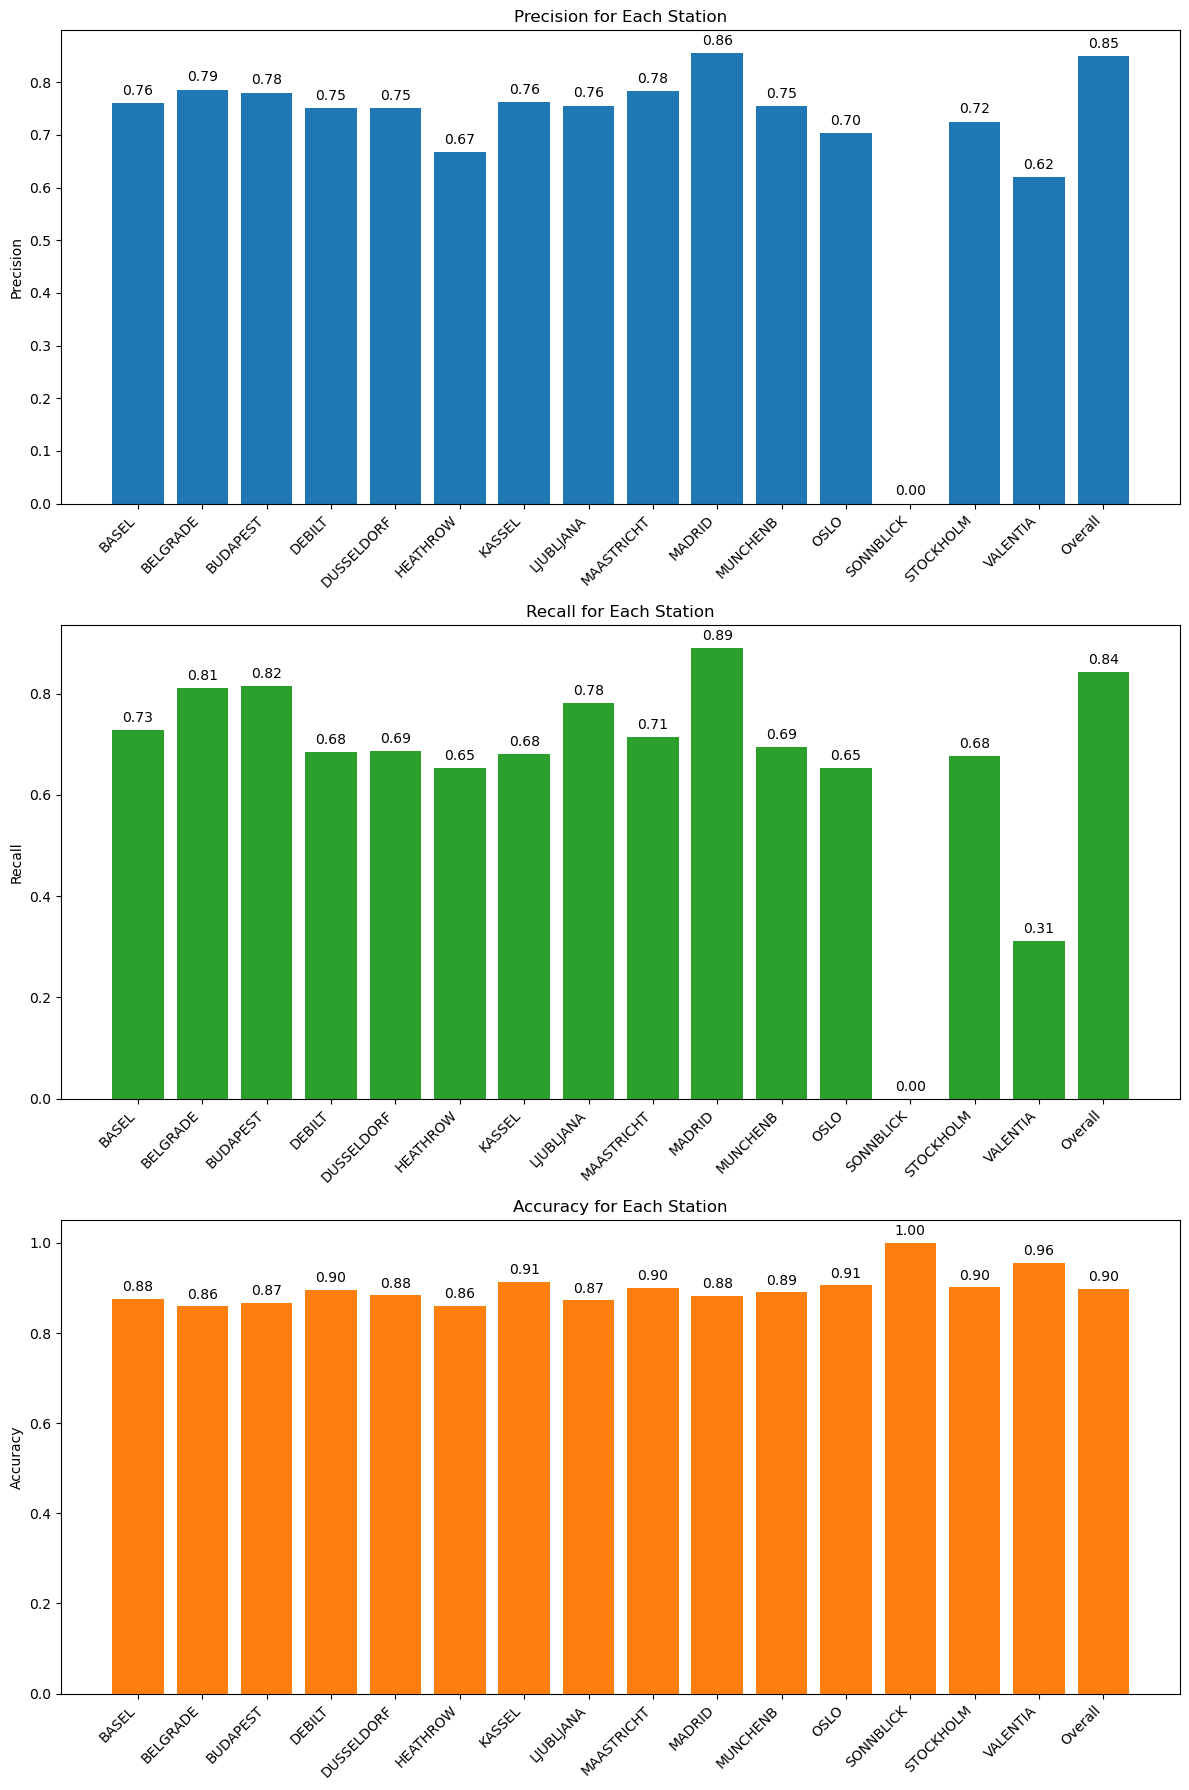

In [33]:
# Plot precision, recall, and accuracy for each station
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Precision plot
axes[0].bar(metrics_df['Station'], metrics_df['Precision'], color='tab:blue')
axes[0].set_title('Precision for Each Station')
axes[0].set_ylabel('Precision')
axes[0].set_xticklabels(metrics_df['Station'], rotation=45, ha='right')
for i, v in enumerate(metrics_df['Precision']):
    axes[0].text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

# Recall plot
axes[1].bar(metrics_df['Station'], metrics_df['Recall'], color='tab:green')
axes[1].set_title('Recall for Each Station')
axes[1].set_ylabel('Recall')
axes[1].set_xticklabels(metrics_df['Station'], rotation=45, ha='right')
for i, v in enumerate(metrics_df['Recall']):
    axes[1].text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

# Accuracy plot
axes[2].bar(metrics_df['Station'], metrics_df['Accuracy'], color='tab:orange')
axes[2].set_title('Accuracy for Each Station')
axes[2].set_ylabel('Accuracy')
axes[2].set_xticklabels(metrics_df['Station'], rotation=45, ha='right')
for i, v in enumerate(metrics_df['Accuracy']):
    axes[2].text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(r'C:\Users\dacol\Documents\Data Project - careerfoundry\ClimateWins_ML\04 Analysis\Visualizations\Scores-KNN.png', bbox_inches='tight', dpi=300)
plt.show()


## 4. K-nearest neighbor on discriminated stations and all weather metrics
<div id='4'></div>

In [31]:
# List of weather stations
stations = locations

# Initialize dictionaries to store models, scores, and confusion matrices
models = {}
scores = {}
y_train_dict = {}
y_test_dict = {}
y_pred_train_dict = {}
y_pred_test_dict = {}

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train and predict using KNN models for each station
for station in stations:
    # Prepare the data for the station
    X_station = X_scaled[:, [j for j, col in enumerate(X.columns) if col.startswith(station)]]
    y_station = y[station + '_pleasant_weather']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_station, y_station, test_size=0.3, random_state=42)
    
    # Create and train the KNN model
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    
    # Predict the labels for training and testing data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate the accuracy score
    score = accuracy_score(y_test, y_pred_test)
    scores[station] = score
    
    # Store the true labels and predictions
    y_train_dict[station] = y_train
    y_test_dict[station] = y_test
    y_pred_train_dict[station] = y_pred_train
    y_pred_test_dict[station] = y_pred_test


In [43]:
# Print accuracy scores for each station
for station, score in scores.items():
    print(f'{station}: Accuracy = {score:.4f}')

BASEL: Accuracy = 0.9322
BELGRADE: Accuracy = 0.9178
BUDAPEST: Accuracy = 0.9370
DEBILT: Accuracy = 0.9348
DUSSELDORF: Accuracy = 0.9332
HEATHROW: Accuracy = 0.9336
KASSEL: Accuracy = 0.9495
LJUBLJANA: Accuracy = 0.9129
MAASTRICHT: Accuracy = 0.9387
MADRID: Accuracy = 0.9370
MUNCHENB: Accuracy = 0.9393
OSLO: Accuracy = 0.9442
SONNBLICK: Accuracy = 1.0000
STOCKHOLM: Accuracy = 0.9590
VALENTIA: Accuracy = 0.9760


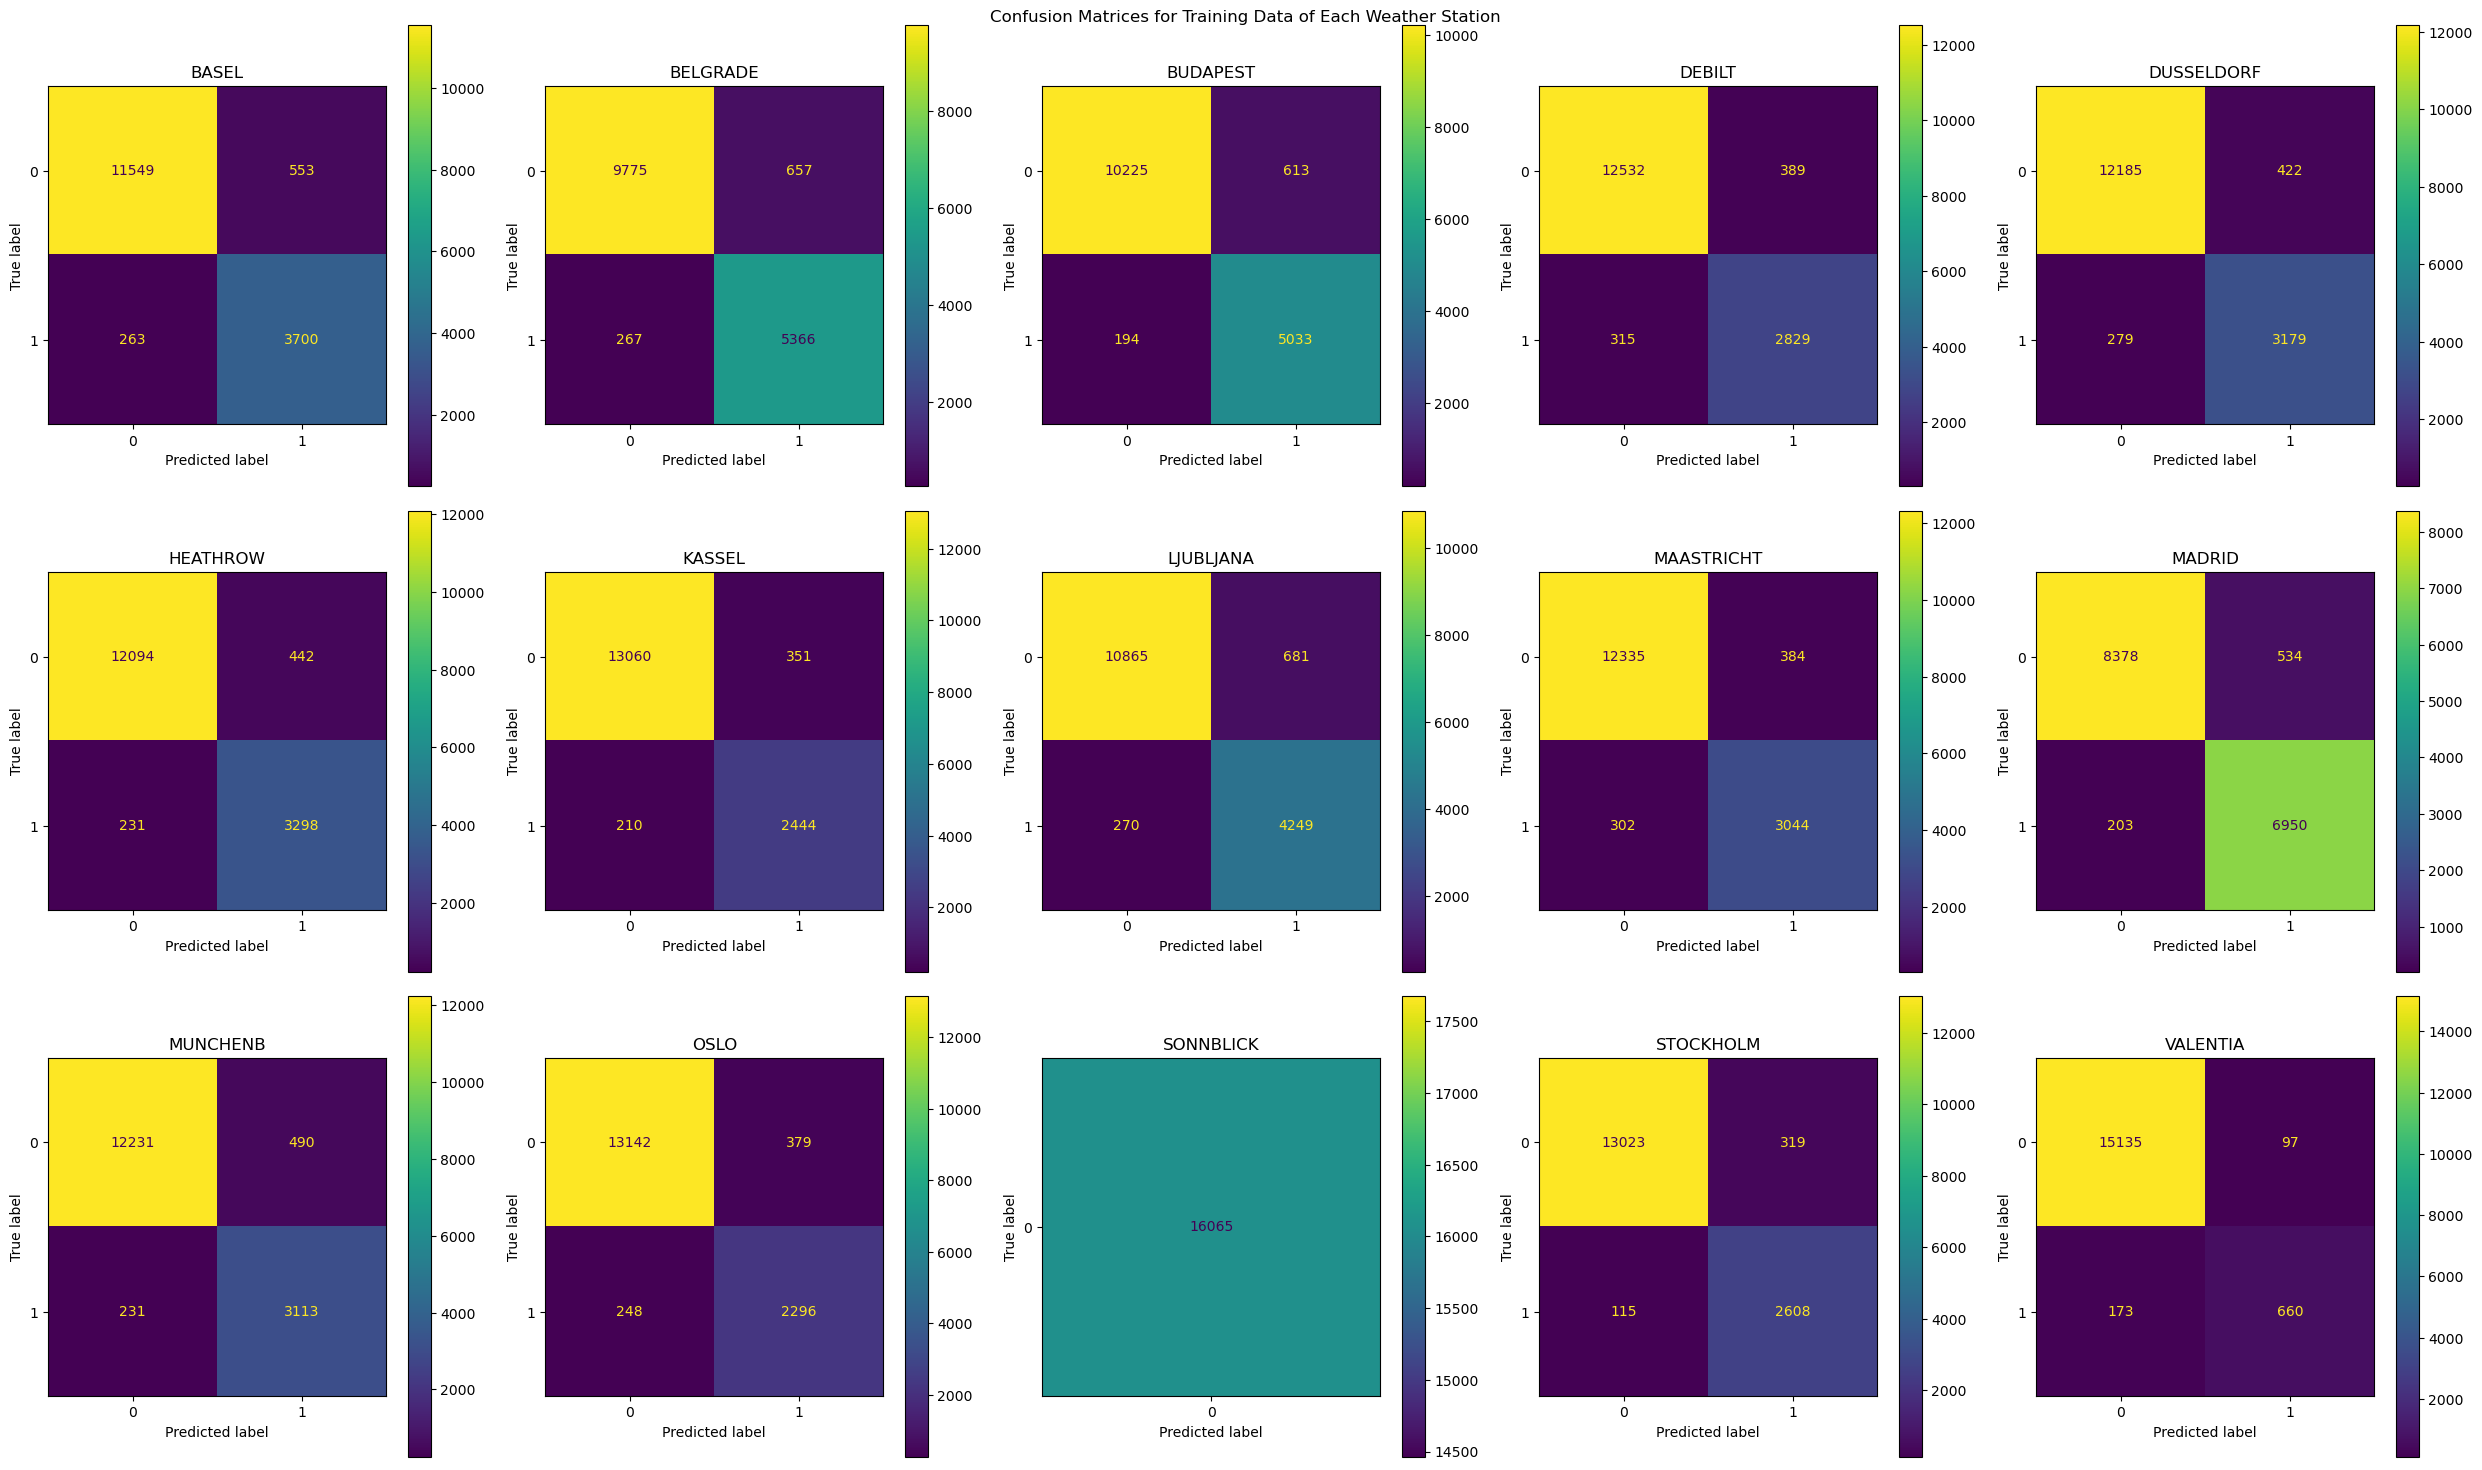

In [33]:
# Create and display confusion matrices for training data
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
fig.suptitle('Confusion Matrices for Training Data of Each Weather Station')

for i, station in enumerate(stations):
    # Get the true labels and predictions for the station
    y_train_station = y_train_dict[station]
    y_pred_train_station = y_pred_train_dict[station]
    
    # Create the confusion matrix
    cm = confusion_matrix(y_train_station, y_pred_train_station)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    ax = axes[i // 5, i % 5]
    disp.plot(ax=ax, values_format='d')
    ax.set_title(station)

plt.tight_layout()
plt.show()

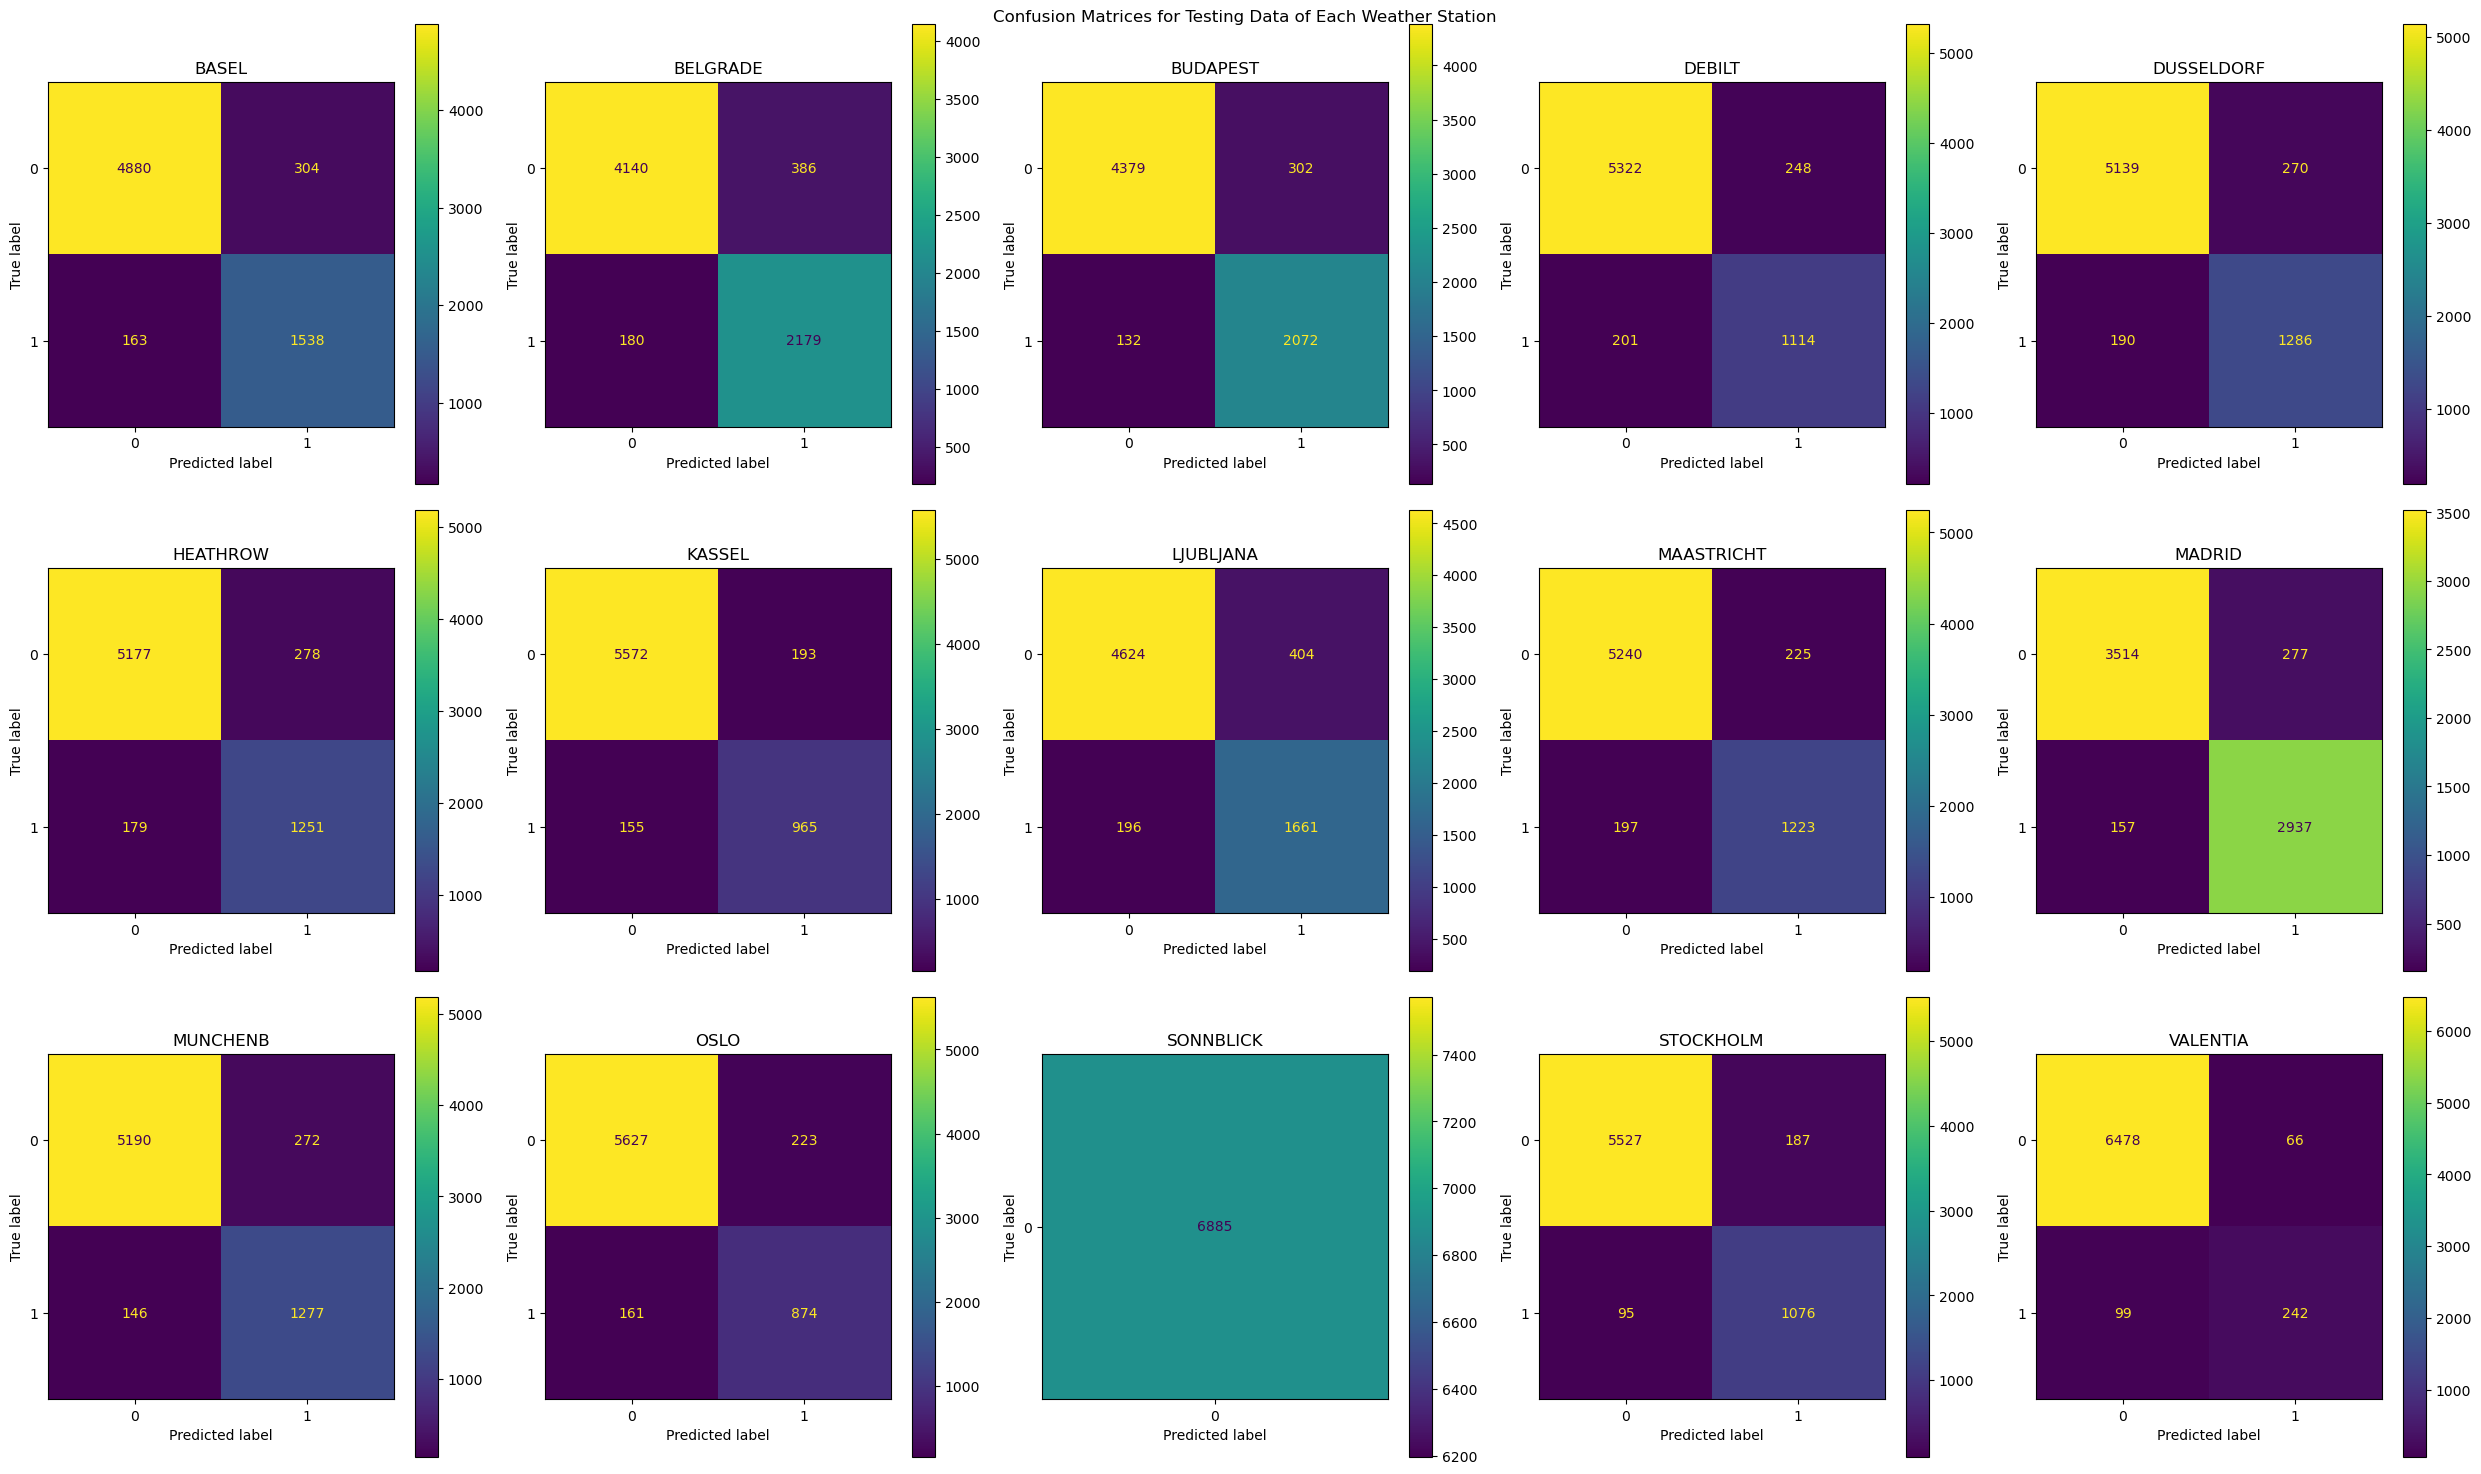

In [35]:
# Create and display confusion matrices for testing data
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
fig.suptitle('Confusion Matrices for Testing Data of Each Weather Station')

for i, station in enumerate(stations):
    # Get the true labels and predictions for the station
    y_test_station = y_test_dict[station]
    y_pred_test_station = y_pred_test_dict[station]
    
    # Create the confusion matrix
    cm = confusion_matrix(y_test_station, y_pred_test_station)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    ax = axes[i // 5, i % 5]
    disp.plot(ax=ax, values_format='d')
    ax.set_title(station)

plt.tight_layout()
plt.savefig(r'C:\Users\dacol\Documents\Data Project - careerfoundry\ClimateWins_ML\04 Analysis\Visualizations\cm_KNN_testing.png', bbox_inches='tight', dpi=300)
plt.show()
